# Ingeniería de Características (Feature Engineering) de Base de Datos de EMOTHAW

**Proyecto Integrador TC5035.10**

**Profesor Asesor:**
- Dra. Ludivina Facundo (ITESM)


**Profesores Investigadores/Tutores:**
- Dr. Juan Arturo Nolazco (ITESM)
- Dr. Marcos Faunez Zaunuy (TecnoCampus Barcelona)

**Equipo 11:** 
- Francisco José Arellano Montes (A01794283)
- Armando Bringas Corpus (A01200230)
- Moisés Díaz Malagón (A01208580)

## Importación de librerías

In [42]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pywt
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA

# Bibliotecas para visualización
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos de la fase de EDA

Cargado de los datos preprocesados en la fase de EDA. 

TODO: mencionar que en el EDA ya se aleatorizaron los datos con la función train_test_split

In [43]:
def cargar_datos():
    """
    Carga los datos preprocesados del análisis exploratorio
    """
    X_train = pd.read_parquet('../data/raw_binary/X_train.parquet')
    y_train = pd.read_parquet('../data/raw_binary/y_train.parquet')
    X_val = pd.read_parquet('../data/raw_binary/X_val.parquet')
    y_val = pd.read_parquet('../data/raw_binary/y_val.parquet')
    X_test = pd.read_parquet('../data/raw_binary/X_test.parquet')
    y_test = pd.read_parquet('../data/raw_binary/y_test.parquet')
    return X_train, y_train, X_val, y_val, X_test, y_test

In [44]:
X_train, y_train, X_val, y_val, X_test, y_test = cargar_datos()


In [45]:
x_mean = X_train['x'].explode().mean()
x_std = X_train['x'].explode().std()
y_mean = X_train['y'].explode().mean()
y_std = X_train['y'].explode().std()

In [46]:
X_train.head(1)

,homework,pen_status,x,y,azimuth,altitude,pressure
Subject,,,,,,,
126,4,1,"[38473, 38481, 38490, 38499, 38514, 38531, 385...","[15452, 15453, 15454, 15458, 15463, 15469, 154...","[3440, 3440, 3440, 3430, 3430, 3430, 3430, 343...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...","[16, 24, 25, 29, 29, 31, 35, 42, 55, 70, 80, 9..."


In [47]:
X_train.shape

(476, 7)

In [48]:
normalized_x = (X_train['x'] - x_mean) / x_std
normalized_y = (X_train['y'] - y_mean) / y_std

In [49]:
normalized_train_df = pd.concat([X_train[['homework','pen_status']], normalized_x, normalized_y], axis=1)

In [50]:
normalized_train_df.head()

,homework,pen_status,x,y
Subject,,,,
126,4,1,"[0.4658252256020692, 0.4664245172768823, 0.467...","[-0.419896948011008, -0.4197981474091503, -0.4..."
107,1,1,"[1.3548744251872404, 1.3542002220530756, 1.353...","[1.4572156866842116, 1.4572156866842116, 1.457..."
17,4,1,"[0.12310529906835183, 0.1216819813406708, 0.12...","[-0.3204047419402629, -0.3213927479588403, -0...."
25,6,0,"[-0.43461051580455, -0.44487338573572366, -0.4...","[-0.6641320358033436, -0.6390366829314773, -0...."
100,3,1,"[0.45870863696366415, 0.4617050953377294, 0.46...","[1.7489738639701204, 1.7489738639701204, 1.748..."


# Data Augmentation

In [51]:
normalized_train_df.iloc[1][['x','y']].values[0].shape
normalized_train_df.iloc[1][['x','y']].values[1].shape

(755,)

In [52]:
original_x_y_arrays = normalized_train_df.iloc[1][['x','y']].values 
random_noise_x = np.random.normal(0, 0.01, size=original_x_y_arrays[0].shape)
random_noise_y = np.random.normal(0, 0.01, size=original_x_y_arrays[1].shape)
new_x_data = original_x_y_arrays[0] + random_noise_x  # Add noise
new_y_data = original_x_y_arrays[1] + random_noise_y  # Add noise


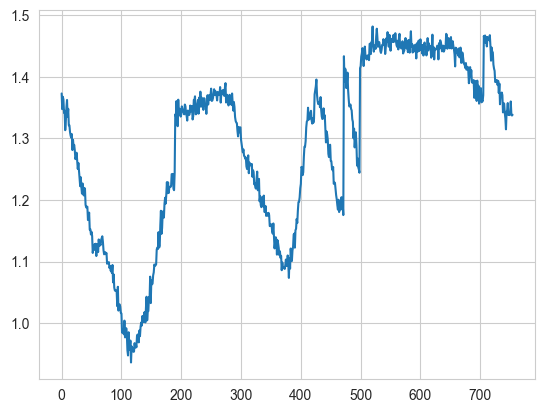

In [53]:
plt.plot(new_x_data)

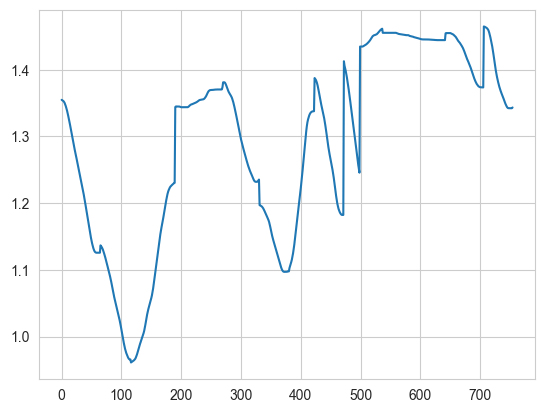

In [54]:
plt.plot(original_x_y_arrays[0])

Elije filas al azar y las aumenta con ruido gaussiano

In [55]:
SCALE = 0.01
PROPORTION = 0.2
np.random.seed(42)

def augment_data(df):
    qty_rows_to_augment = int(PROPORTION * df.shape[0])
    df_augmented = df.copy()
    
    for _ in range(qty_rows_to_augment):  # Create new N data
        target_row = np.random.randint(0, df.shape[0] - 1)  # Randomly select a row
        original_x_y_arrays = df.iloc[target_row][['x','y']].values 
        
        # Generate Gaussian noise with the same shape as the selected row
        random_noise_x = np.random.normal(0, SCALE, size=original_x_y_arrays[0].shape)
        random_noise_y = np.random.normal(0, SCALE, size=original_x_y_arrays[1].shape)
        new_x_data = original_x_y_arrays[0].shape + random_noise_x  # Add noise
        new_y_data = original_x_y_arrays[1].shape + random_noise_y  # Add noise
        
        # Convert to DataFrame and maintain original structure
        augmented_row = {
            'x': new_x_data,
            'y': new_y_data,
            'homework': df.iloc[target_row]['homework'],
            'pen_status': df.iloc[target_row]['pen_status'],
        }
        augmented_row = pd.DataFrame([augmented_row])
        
        # Concatenate the augmented row to the original dataset
        df_augmented = pd.concat([df_augmented, augmented_row], ignore_index=True, axis=0)
    
    return df_augmented	

In [56]:
df_augmented = augment_data(normalized_train_df)

In [57]:
normalized_train_df.shape, df_augmented.shape

((476, 4), (571, 4))

TODO: agregar comentario que se aumento 20% del original (476)

## Ingeniería de Características

### Extracción de Características Wavelet

Implementamos la transformación wavelet para capturar características tanto en frecuencia como temporales:

In [58]:
class WaveletTransformer(BaseEstimator, TransformerMixin):
    '''
    Custom scikit transformer for wavelet transformation of time-series data.
    '''

    def _extract_wavelet_features(self, data_list, wavelet='db4', level=10):
        """
        Aplicar la Transformada Wavelet a una lista de datos y extraer características.

        Parámetros:
        data_list = lista de datos a usar.
        wavelet = transformacion wavelet a usar (Daubechies 4 wavelet)
        level = número de veces que se realiza el proceso de descomposición en una señal o imagen
        """
        coeffs = pywt.wavedec(data_list, wavelet, level=level)
        features = []
        for coef in coeffs:
            features.extend([
                np.mean(coef),
                np.std(coef),
                np.min(coef),
                np.max(coef)
            ])
        return features
    
    def fit(self, X, y=None):
        # stateless transformer
        self.column_names = list(X.columns)

        return self
    
    def transform(self, X, y=None):
        return X.apply(self._batch_process)
    
    def _apply_transformation(self, window, column_name):
        return self._extract_wavelet_features(window)

    def _batch_process(self, column):
        return column.map(lambda col_val: self._apply_transformation(col_val, column.name))
    
    def get_feature_names_out(self, column_names):
        return self.column_names

In [59]:
wavelet_transformer = WaveletTransformer()

numerical_columns = ['x', 'y']

col_transformer = ColumnTransformer([
    ('wavelet', wavelet_transformer, numerical_columns)
], remainder='passthrough')
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('wavelet', WaveletTransformer(), ['x', 'y'])])

In [60]:
wavelet_train_df = col_transformer.fit_transform(df_augmented)
column_names = [x.split('__')[-1] for x in col_transformer.get_feature_names_out()] # get column names back again
wavelet_train_df = pd.DataFrame(wavelet_train_df, columns=column_names) # transformer generates matrix, convert back to dataframe

C:\Users\arman\AppData\Local\pypoetry\Cache\virtualenvs\proyecto-integrador-equipo-11-WxcN3L0e-py3.12\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [61]:
wavelet_train_df

,x,y,homework,pen_status
0,"[12.148005488777905, 4.611343995005918, 1.8580...","[-13.580025434111302, 1.370950774193394, -16.9...",4,1
1,"[43.10940807817893, 1.0221309208777931, 41.047...","[42.39905209640803, 8.715453443123613, 21.8172...",1,1
2,"[3.050218115248705, 1.6621247238320849, -0.878...","[-10.080347079861946, 0.5732943476219098, -10....",4,1
3,"[-15.887530530241712, 2.3744107757497095, -21....","[-21.698861454684895, 1.576843366787542, -24.7...",6,0
4,"[5.7166253176828485, 17.31012802124303, -33.80...","[51.69157672039583, 6.411944447410344, 38.8289...",3,1
...,...,...,...,...
566,"[54656.11005251284, 0.047783318888902596, 5465...","[54656.049069048546, 0.036422233955932054, 546...",6,0
567,"[25600.1061890809, 0.0783055755567984, 25599.9...","[25599.841231014194, 0.12528839003204634, 2559...",3,0
568,"[47519.830010511396, 0.05926905641596754, 4751...","[47520.020861697754, 0.06343797238265692, 4751...",7,0
569,"[50144.01728368786, 0.0908948139487935, 50143....","[50144.08614492719, 0.08725972279251756, 50143...",3,1


Usando la transformada wavelet, las señales `x` y `y` se descomponen en 44 características representativas que capturan información estadística (media, desviación estándar, mínimos y máximos) a través de coeficientes wavelet. La wavelet captura patrones en las señales que pueden no ser evidentes en el dominio temporal original.

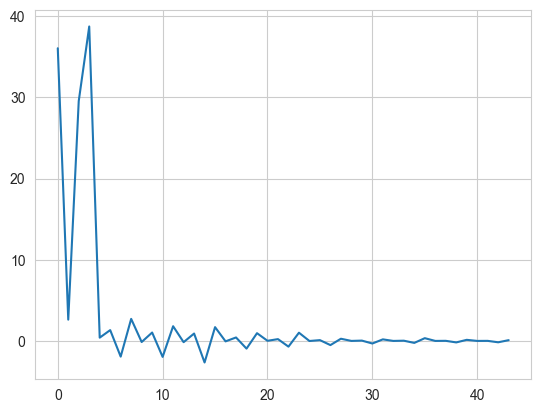

In [62]:
plt.plot(wavelet_train_df.iloc[10]['x'])

Previo a reducir la dimensionalidad, es necesario expandir los array de datos tanto X como Y. 

In [63]:
# flatten data 
x_train_data = pd.DataFrame(wavelet_train_df['x'].to_list())
y_train_data = pd.DataFrame(wavelet_train_df['y'].to_list())

### LLE

Locally Linear Embedding (LLE) es un algoritmo de reducción de dimensionalidad no lineal que busca preservar la estructura local de los datos. Se basa en la hipótesis de que los datos de alta dimensión están distribuidos en un manifold (una superficie de menor dimensión) y que las relaciones locales entre los puntos se pueden capturar y mantener en un espacio de menor dimensionalidad.

A diferencia de métodos como PCA (Análisis de Componentes Principales), que utiliza una proyección lineal para reducir la dimensionalidad, LLE utiliza las relaciones locales de cada punto con sus vecinos más cercanos. Esto le permite capturar estructuras no lineales presentes en los datos y obtener una representación más precisa de su geometría intrínseca.

Al momento de aplicar LLE para reducir la dimensionalidad, es necesario identificar los valores óptimos de los parámetros clave en el siguiente orden:

1. **`n_neighbors`**: número de vecinos a considerar para la reconstrucción de cada punto, define la estructura local que LLE utilizará para mapear los datos. Si los vecinos no están correctamente seleccionados, el mapeo será incorrecto, sin importar el número de componentes (`n_components`) utilizados. Muy pocos vecinos no pueden captar suficiente información local, mientras que demasiados vecinos pueden incluir relaciones no relevantes.


2. **`n_components`**: número de componentes a extraer. Una vez definido el parámetro `n_neighbors`, que asegura una representación adecuada de la estructura local, es posible enfocarse en cuántas dimensiones retener. Este parámetro está relacionado con la dimensionalidad intrínseca de los datos por lo que, más componentes retienen más información pero también pero pueden introducir redundancia o ruido.

#### Selección de **`n_neighbors`**

In [71]:
def plot_reconstruction_error_neighbors(x_train_data, n_components=35, max_neighbors=20):

    errors = []
    for neighbors in range(2, max_neighbors + 1):
        embedding = LocallyLinearEmbedding(n_components=n_components, n_neighbors=neighbors, eigen_solver='dense')
        embedding.fit(x_train_data)
        errors.append(embedding.reconstruction_error_)

    plt.plot(range(2, max_neighbors + 1), errors)
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Reconstruction Error')
    plt.title('Selecting n_neighbors using Reconstruction Error')
    plt.show()


La función `plot_reconstruction_error_neighbors` permite visualizar el error de reconstrucción en función del número de vecinos para distintos valores de n_neighbors con un número fijo de componentes. En este caso, de acuerdo a la gráfica se puede seleccionar un rango entre 5 a 10 vecinos para minimizar el error de reconstrucción. 

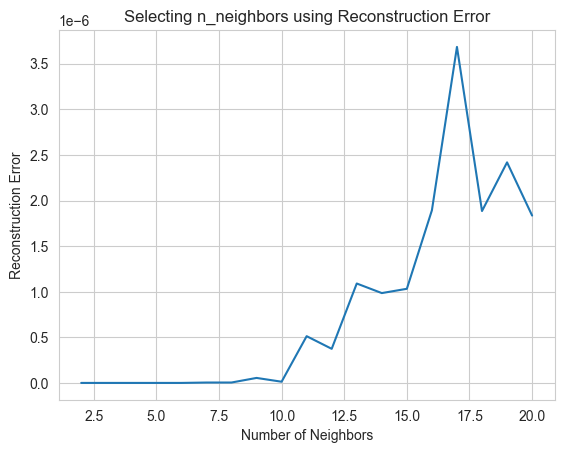

In [72]:
plot_reconstruction_error_neighbors(x_train_data, n_components=6, max_neighbors=20)

#### Selección de **`n_components`**

In [73]:
def plot_lle_reconstruction_errors(x_train_data, max_components=35, n_neighbors=4):
    """
    """
    errors = []
    for n in range(1, max_components + 1):
        embedding = LocallyLinearEmbedding(n_components=n, n_neighbors=n_neighbors, eigen_solver='dense')
        embedding.fit(x_train_data)
        errors.append(embedding.reconstruction_error_)

    plt.plot(range(1, max_components + 1), errors)
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    plt.title('Selecting n_components using Reconstruction Error')
    plt.show()

La función `plot_lle_reconstruction_errors` permite visualizar el error de reconstrucción en función del número de componentes seleccionados, el gráfico generado nos permite identificar el "punto de codo" (elbow point) donde agregar más componentes no reduce significativamente el error. En este caso podemos seleccionar entre 20 a 25 componentes.

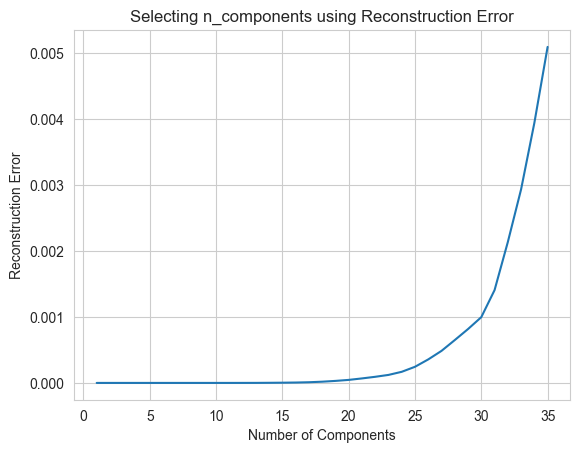

In [74]:
plot_lle_reconstruction_errors(x_train_data, max_components=35, n_neighbors=5)


In [67]:
embedding = LocallyLinearEmbedding(n_components=25, n_neighbors=5)
lle_train_data = embedding.fit_transform(x_train_data)
lle_train_data.shape

(571, 25)

In [86]:
def visualize_multiple_components(X_reduced, num_components=20):
    """
    """
    num_plots = min(num_components, X_reduced.shape[1]) // 2
    rows = (num_plots + 1) // 2  # Dividir las gráficas en dos renglones
    fig, axes = plt.subplots(rows, 2, figsize=(20, 10))
    axes = axes.flatten()

    for i in range(num_plots):
        scatter = axes[i].scatter(X_reduced[:, 2 * i], X_reduced[:, 2 * i + 1], c=X_reduced[:, 2 * i], cmap=plt.cm.Spectral)
        axes[i].set_title(f"Componentes {2 * i + 1} vs {2 * i + 2}")
        axes[i].set_xlabel(f"Componente {2 * i + 1}")
        axes[i].set_ylabel(f"Componente {2 * i + 2}")
        fig.colorbar(scatter, ax=axes[i], orientation='vertical')

    # Eliminar ejes vacíos si num_plots no es par
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

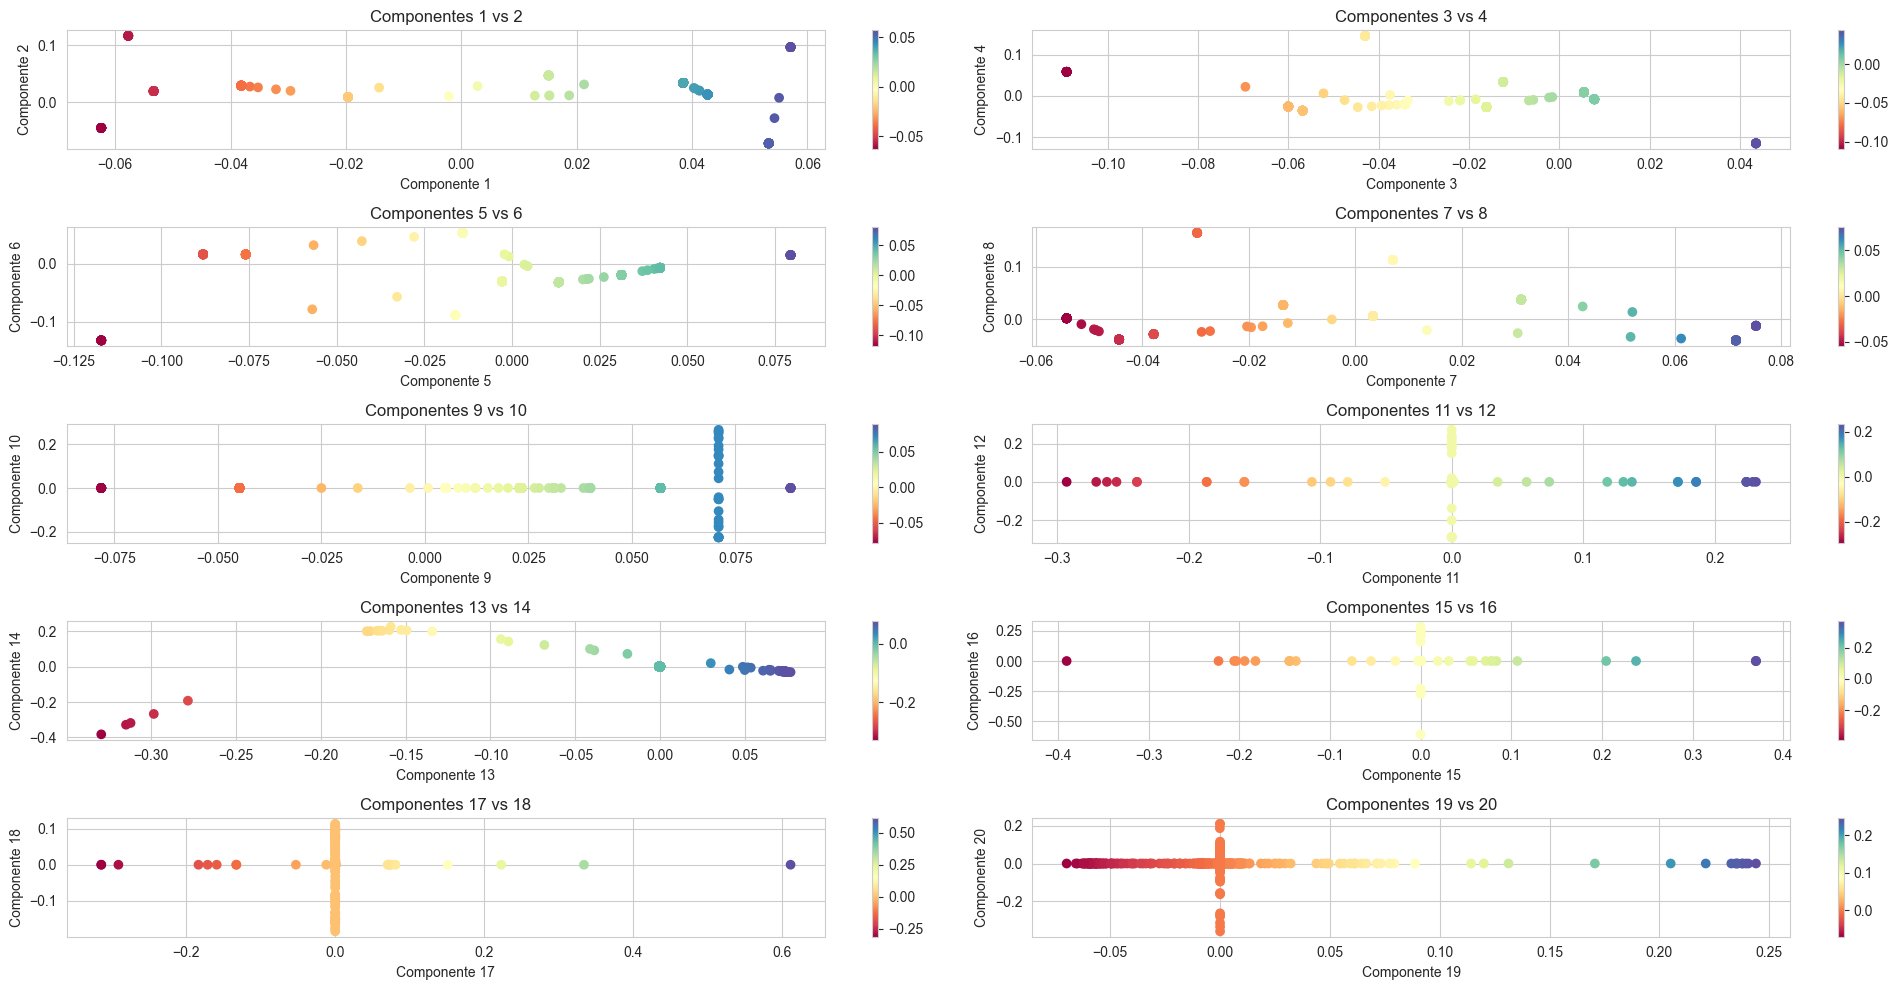

In [87]:
visualize_multiple_components(lle_train_data, num_components=20)

La gráfica representa los datos reducidos utilizando Locally Linear Embedding (LLE). En este caso, las 20 componentes seleccionadas (resultado del análisis de codo) se muestran en pares consecutivos para facilitar su análisis. Cada subgráfico muestra un par de componentes, los pares de componentes se visualizan en ejes X y Y, permitiendo identificar cómo los datos se distribuyen en el espacio reducido.

En cada subgráfico, puedes observar cómo los puntos se agrupan o separan. Al observar que se presentan agrupaciones claras o regiones de densidad, esto quiere decir que las relaciones locales fueron bien preservadas por el LLE.

### PCA

In [68]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca_train_data = pca.fit_transform(x_train_data)
pca_train_data.shape


(571, 6)

### Normalización

## Implementación del Pipeline

In [69]:
def crear_pipeline_completo():
    columnas_numericas = ['x', 'y', 'azimuth', 'altitude', 'pressure']
    pipeline_caracteristicas = Pipeline([
        ('escalador', EscaladorRobustoSerieTemporal()),
        ('wavelet', ExtractorCaracteristicasWavelet()),
        ('estadisticas', CaracteristicasEstadisticasSeriesTiempo())
    ])
    preprocesador = ColumnTransformer(
        transformers=[
            ('numericas', pipeline_caracteristicas, columnas_numericas)
        ],
        remainder='passthrough'
    )
    return preprocesador

In [70]:
# Crear y ajustar pipeline
pipeline = crear_pipeline_completo()
X_train_transformado = pipeline.fit_transform(X_train)
X_val_transformado = pipeline.transform(X_val)
X_test_transformado = pipeline.transform(X_test)

# Convertir a DataFrame para mejor manejo
columns = [f'caracteristica_{i}' for i in range(X_train_transformado.shape[1])]
X_train_transformado = pd.DataFrame(X_train_transformado, columns=columns)
X_val_transformado = pd.DataFrame(X_val_transformado, columns=columns)
X_test_transformado = pd.DataFrame(X_test_transformado, columns=columns)

# Mostrar dimensiones y primeras filas
print("Dimensiones después de la transformación:")
print(f"Train: {X_train_transformado.shape}")
print(f"Validación: {X_val_transformado.shape}")
print(f"Test: {X_test_transformado.shape}")

X_train_transformado.head()

NameError: name 'EscaladorRobustoSerieTemporal' is not defined

# Shuffle y partición de datos

## Visualización y Análisis 

In [ ]:
def visualizar_transformaciones(X_transformado):
    """
    Genera visualizaciones para validar las transformaciones
    """
    # Seleccionamos las primeras 20 características para visualización
    X_vis = X_transformado.iloc[:, :20]
    
    # Creamos la figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. Distribución de características usando violinplot
    sns.violinplot(data=X_vis, ax=ax1)
    ax1.set_title('Distribución de las Primeras 20 Características')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
    # 2. Matriz de correlación
    sns.heatmap(X_vis.corr(), 
                cmap='coolwarm', 
                center=0,
                ax=ax2)
    ax2.set_title('Correlación entre Características')
    
    plt.tight_layout()
    return fig

# Visualizar características extraídas para cada tipo de señal
def visualizar_caracteristicas_por_tipo(X_transformado):
    """
    Visualiza las características extraídas agrupadas por tipo de señal original
    """
    tipos_señal = ['x', 'y', 'azimuth', 'altitude', 'pressure']
    
    for tipo in tipos_señal:
        # Seleccionar columnas relacionadas con este tipo de señal
        cols = [col for col in X_transformado.columns if tipo in col]
        if cols:
            plt.figure(figsize=(15, 6))
            
            # Boxplot para las características
            sns.boxplot(data=X_transformado[cols])
            plt.title(f'Características extraídas de la señal {tipo}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Función para visualizar la descomposición wavelet
def visualizar_wavelet(señal_original, nivel=3, wavelet='db4'):
    """
    Visualiza la descomposición wavelet de una señal
    """
    # Realizar la descomposición wavelet
    coefs = pywt.wavedec(señal_original, wavelet, level=nivel)
    
    # Crear la figura
    fig, axes = plt.subplots(nivel + 2, 1, figsize=(15, 3*(nivel+2)))
    
    # Plotear señal original
    axes[0].plot(señal_original)
    axes[0].set_title('Señal Original')
    
    # Plotear coeficientes de aproximación
    axes[1].plot(coefs[0])
    axes[1].set_title('Coeficientes de Aproximación')
    
    # Plotear coeficientes de detalle
    for i, coef in enumerate(coefs[1:], 2):
        axes[i].plot(coef)
        axes[i].set_title(f'Coeficientes de Detalle Nivel {i-1}')
    
    plt.tight_layout()
    return fig


In [ ]:
# Ejecutar visualizaciones
try:
    # Visualización general de características
    fig1 = visualizar_transformaciones(X_train_transformado)
    plt.show()
    
    # Visualización por tipo de señal
    visualizar_caracteristicas_por_tipo(X_train_transformado)
    
    # Ejemplo de descomposición wavelet para una señal
    señal_ejemplo = X_train['x'].iloc[0]  # Primera señal x
    fig3 = visualizar_wavelet(señal_ejemplo)
    plt.show()
    
except Exception as e:
    print(f"Error en la visualización: {str(e)}")

## Conclusiones

## Referencias